In [1]:
import torchvision
import cv2
from pytorch_tiramisu.models import *
from torch import nn
import torch
from torch.autograd import Variable
from torchvision.utils import save_image
import pytorch_tiramisu.utils.training as train_utils

from model import FCDenseNet67

In [2]:
import warnings
from matplotlib import *
from pylab import *

In [3]:
import albumentations as albu
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.core.composition import Compose
from albumentations.augmentations.transforms import Resize
from albumentations.pytorch import ToTensor
from albumentations.augmentations.transforms import LongestMaxSize, PadIfNeeded

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from tqdm import tnrange, tqdm_notebook
import time
from os.path import join, exists
from os import makedirs
from tensorboardX import SummaryWriter
import json

%matplotlib inline

In [4]:
IMAGES_DIR = os.path.join('.', 'ISIC-Archive-Downloader', 'Data', 'Images')
IMAGES_DIR = os.path.join('.', 'ISIC-Archive-Downloader', 'Data', 'resized_images')
BATCH_SIZE = 4

In [5]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [6]:
class VAE_CNN(nn.Module):
    def __init__(self):
        super(VAE_CNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(25 * 25 * 16, 2048)
        self.fc_bn1 = nn.BatchNorm1d(2048)
        self.fc21 = nn.Linear(2048, 2048)
        self.fc22 = nn.Linear(2048, 2048)

        # Sampling vector
        self.fc3 = nn.Linear(2048, 2048)
        self.fc_bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 25 * 25 * 16)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 25 * 25 * 16)
        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))
        fc4 = fc4.view(-1, 16, 25, 25)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 3, 100, 100)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [7]:
def metrics(x_recon, x, mu, logvar):
    mse_loss = nn.MSELoss(reduction="sum")
    loss_MSE = mse_loss(x_recon, x)
    loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss_MSE, loss_KLD

In [8]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return 0.01*loss_MSE + loss_KLD

In [9]:
class CustomDataset(Dataset):
    def __init__(self, paths, means=[], stds=[], base_path=IMAGES_DIR):
        self.paths = paths
        self.base_path = base_path
        #normalize={'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
        self.transform = Compose([
                                Resize(100, 100),
                                #LongestMaxSize(max_size=224), 
                                #PadIfNeeded(min_height=224, min_width=224),
                                ToTensor()])
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        image_path = self.paths[index]
        image = cv2.imread(join(self.base_path, image_path))[..., ::-1]
        image_tensor = self.transform(image=image)['image']
        return image_tensor

In [10]:
def create_logdirs(modeldir):
    cur_time_str = time.ctime().replace(' ', '_').replace(':', '-')
    tb_dir = join(modeldir, 'logs', cur_time_str)
    runs_dir = join(modeldir, 'runs', cur_time_str)
    if not exists(tb_dir):
        makedirs(tb_dir)
    if not exists(runs_dir):
        makedirs(runs_dir)
    return tb_dir, runs_dir

In [11]:
def train(model, training_generator, valid_generator, optimizer, criterion, batch_size, epochs=60):
    log_interval = 500
    val_losses = []
    train_losses = []
    loss_MSE_ts = []
    loss_KLD_ts = []
    
    for epoch in range(1, epochs + 1):
        
        train_loss = 0
        loss_MSE_t=0
        loss_KLD_t=0
        tb_dir, runs_dir = create_logdirs('./logs/')
        writer = SummaryWriter(tb_dir)
        
        model.train()
        for batch_idx, data in tqdm_notebook(enumerate(training_generator), desc='train', total=len(training_generator)):
            data = data.cuda()
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD = metrics(recon_batch, data, mu, logvar)
            loss = criterion(recon_batch, data, mu, logvar)
            loss.backward()
            loss_MSE_t+=loss_MSE
            loss_KLD_t+=loss_KLD
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, MSE: {:.6f}, KLD: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(training_generator),
                           100. * batch_idx / len(training_generator),
                           loss.item() / (batch_idx+1), loss_MSE_t / (batch_idx+1), loss_KLD_t / (batch_idx+1)))
            writer.add_scalar('Train/loss', loss.item() / (batch_idx+1), epoch*len(training_generator)+batch_idx)
        train_losses.append(train_loss / len(training_generator))
        loss_MSE_ts.append(loss_MSE_t / len(training_generator))
        loss_KLD_ts.append(loss_KLD_t / len(training_generator))
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(training_generator)))
        writer.add_scalar('Train/Average Loss', train_loss / len(training_generator), epoch)
        
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, data in tqdm_notebook(enumerate(valid_generator), desc='val', total=len(valid_generator)):
                data = data.cuda()
                recon_batch, mu, logvar = model(data)
                test_loss += criterion(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                            recon_batch.view(batch_size, 3, 100, 100)[:n]])
                    save_image(comparison.cpu(),
                               './results/reconstruction_' + str(epoch) + '.png', nrow=n)

        test_loss /= len(valid_generator)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        writer.add_scalar('Valid/loss', test_loss, epoch)
        val_losses.append(test_loss)

    
#     with torch.no_grad():
#         sample = torch.randn(64, 2048).to(device)
#         sample = model.decode(sample).cpu()
#         save_image(sample.view(64, 3, 100, 100),
#                    '../results/sample_' + str(epoch) + '.png')

In [12]:
onlyfiles = [f for f in listdir(IMAGES_DIR) if isfile(join(IMAGES_DIR, f))]
X_train, X_test = train_test_split(onlyfiles, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

In [14]:
onlyfiles

['ISIC_0029087.jpeg',
 'ISIC_0001276.jpeg',
 'ISIC_0032689.jpeg',
 'ISIC_0033698.jpeg',
 'ISIC_0005071.jpeg',
 'ISIC_0025538.jpeg',
 'ISIC_0025452.jpeg',
 'ISIC_0029684.jpeg',
 'ISIC_0032700.jpeg',
 'ISIC_0033467.jpeg',
 'ISIC_0030466.jpeg',
 'ISIC_0000619.jpeg',
 'ISIC_0008817.jpeg',
 'ISIC_0002739.jpeg',
 'ISIC_0007794.jpeg',
 'ISIC_0011246.jpeg',
 'ISIC_0000695.jpeg',
 'ISIC_0031492.jpeg',
 'ISIC_0002178.jpeg',
 'ISIC_0002289.jpeg',
 'ISIC_0034284.jpeg',
 'ISIC_0031700.jpeg',
 'ISIC_0026282.jpeg',
 'ISIC_0026057.jpeg',
 'ISIC_0027335.jpeg',
 'ISIC_0005924.jpeg',
 'ISIC_0024278.jpeg',
 'ISIC_0027659.jpeg',
 'ISIC_0007428.jpeg',
 'ISIC_0000226.jpeg',
 'ISIC_0030852.jpeg',
 'ISIC_0011804.jpeg',
 'ISIC_0028271.jpeg',
 'ISIC_0033103.jpeg',
 'ISIC_0031260.jpeg',
 'ISIC_0030194.jpeg',
 'ISIC_0033653.jpeg',
 'ISIC_0007287.jpeg',
 'ISIC_0002318.jpeg',
 'ISIC_0011449.jpeg',
 'ISIC_0024338.jpeg',
 'ISIC_0029710.jpeg',
 'ISIC_0024415.jpeg',
 'ISIC_0003819.jpeg',
 'ISIC_0005970.jpeg',
 'ISIC_000

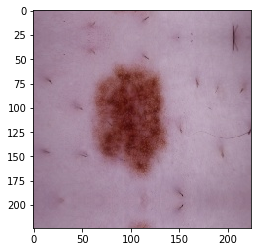

In [13]:
image = cv2.imread(IMAGES_DIR+'/'+'ISIC_0033698.jpeg')[..., ::-1]
imshow(image)

In [34]:
with open('./scaling_params.json', 'r') as json_file:  
    data = json.load(json_file)
    
MEAN = data['MEAN'] 
VAR = data['VAR']

In [15]:
train_dataset =  CustomDataset(X_train, means=MEAN, stds=VAR)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

valid_dataset =  CustomDataset(X_val, means=MEAN, stds=VAR)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset =  CustomDataset(X_test, means=MEAN, stds=VAR)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
# features = []
# for i, inputs in tqdm_notebook(enumerate(train_loader), desc='iter', total=len(train_loader)):
#     if i>500:
#         break
#     features.append(inputs.detach().numpy())
# features = np.concatenate(features)
# print(features.shape)
# #features = np.stack([f.cpu().detach().numpy() for f in features[:5000]])

# MEAN = np.mean(features, axis=(0, 2, 3))
# VAR = np.std(features, axis=(0, 2, 3))

# with open('./scaling_params.json', 'w') as f:
#      json.dump({'MEAN':MEAN.tolist(), 'VAR':VAR.tolist()}, f)

---

In [17]:
# transform = Compose([LongestMaxSize(max_size=224), 
#                         PadIfNeeded(min_height=224, min_width=224)
#                          ])

In [18]:
# for p in tqdm_notebook(onlyfiles):
#     image = cv2.imread(join(IMAGES_DIR, p))
#     image = transform(image=image)['image']
#     cv2.imwrite('./ISIC-Archive-Downloader/Data/resized_images/'+p, image)

---

In [19]:
from pytorch_tiramisu.models.layers import *

class FCDenseNet(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5),
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5,
                 growth_rate=16, out_chans_first_conv=48):
        super().__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks
        cur_channels_count = 0
        skip_connection_channel_counts = []

        ## First Convolution ##

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels,
                  out_channels=out_chans_first_conv, kernel_size=3,
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv

        #####################
        # Downsampling path #
        #####################

        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0,cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))

        #####################
        #     Bottleneck    #
        #####################

        self.add_module('bottleneck',Bottleneck(cur_channels_count,
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels

        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i],
                    upsample=True))
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels

        ## Final DenseBlock ##

        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1],
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]
        
        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=3, kernel_size=1, stride=1,
                   padding=0, bias=True)
        
        bneck_size = 3920
        
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(bneck_size, 2048)
        self.fc_bn1 = nn.BatchNorm1d(2048)
        self.fc21 = nn.Linear(2048, 2048)
        self.fc22 = nn.Linear(2048, 2048)

        # Sampling vector
        self.fc3 = nn.Linear(2048, 2048)
        self.fc_bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, bneck_size)
        self.fc_bn4 = nn.BatchNorm1d(bneck_size)
        self.relu = nn.ReLU()
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        out = self.firstconv(x)

        skip_connections = []
        for i in range(len(self.down_blocks)):
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)

        out = self.bottleneck(out)
        
        shape = out.shape
        out = out.reshape(out.shape[0], -1)
        fc1 = self.relu(self.fc_bn1(self.fc1(out)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        z = self.reparameterize(r1, r2)
        
        #self.decode(z), mu, logvar
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).reshape(*shape)
        out = fc4
        for i in range(len(self.up_blocks)):
            skip = skip_connections.pop()
            out = self.transUpBlocks[i](out, skip)
            out = self.denseBlocksUp[i](out)

        out = self.finalConv(out)
        #out = self.conv8(out).view(-1, 3, 224, 224)
        #out = self.softmax(out)
        return out, r1, r2, z

def FCDenseNet67():
    return FCDenseNet(
        in_channels=3, down_blocks=(5, 5, 5, 5, 5),
        up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5,
        growth_rate=16, out_chans_first_conv=48)

In [20]:
model = FCDenseNet67().cuda()
model.apply(train_utils.weights_init)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = customLoss()
#optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
#criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()

/home/alisa/neuro/pytorch_tiramisu/utils/training.py:102: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight)


In [38]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    train_losses, test_losses, test_r2_losses, train_r2_losses, model = train(model, train_loader, valid_loader, optimizer, criterion, BATCH_SIZE, epochs=60)
    

ooo torch.Size([4, 10000])
fc3 torch.Size([4, 2048])
fc4 torch.Size([4, 10000])
Train Epoch: 1 [0/3825 (0%)]	Loss: 29.426716, MSE: 2463.062256, KLD: 4.796094
ooo torch.Size([4, 10000])
fc3 torch.Size([4, 2048])
fc4 torch.Size([4, 10000])
ooo torch.Size([4, 10000])
fc3 torch.Size([4, 2048])
fc4 torch.Size([4, 10000])
ooo torch.Size([4, 10000])
fc3 torch.Size([4, 2048])
fc4 torch.Size([4, 10000])
ooo torch.Size([4, 10000])
fc3 torch.Size([4, 2048])
fc4 torch.Size([4, 10000])
ooo torch.Size([4, 10000])
fc3 torch.Size([4, 2048])
fc4 torch.Size([4, 10000])
ooo torch.Size([4, 10000])
fc3 torch.Size([4, 2048])
fc4 torch.Size([4, 10000])
ooo torch.Size([4, 10000])
fc3 torch.Size([4, 2048])
fc4 torch.Size([4, 10000])
ooo torch.Size([4, 10000])
fc3 torch.Size([4, 2048])
fc4 torch.Size([4, 10000])
ooo torch.Size([4, 10000])
fc3 torch.Size([4, 2048])
fc4 torch.Size([4, 10000])
ooo torch.Size([4, 10000])
fc3 torch.Size([4, 2048])
fc4 torch.Size([4, 10000])
ooo torch.Size([4, 10000])
fc3 torch.Size(

KeyboardInterrupt: 

In [1]:
torch.save(model, './models/tiramisy_vae_full_isic_3_epochs.pth.tar')

NameError: name 'torch' is not defined

In [2]:
# for name, param in model.named_parameters():
#     print(name)

#### Inference

In [19]:
model = torch.load('./models/tiramisy_vae_full_isic_3_epochs.pth.tar')

In [22]:
z[0]

NameError: name 'z' is not defined

Probability: -0.0


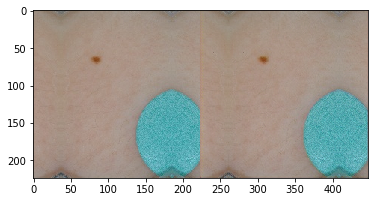

Probability: -0.0


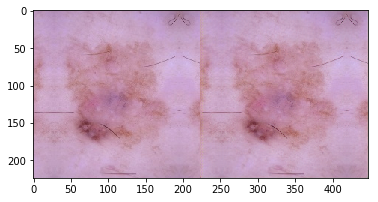

Probability: 0.0


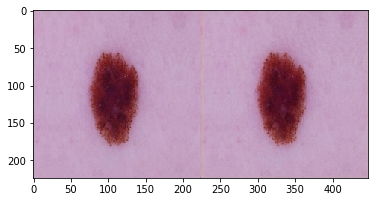

Probability: 0.0


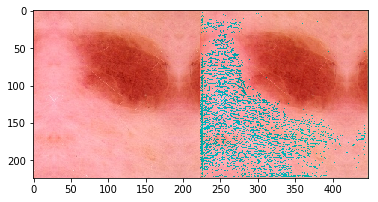

In [30]:
for batch_idx, data in tqdm_notebook(enumerate(valid_loader), desc='train', total=len(valid_loader)):
    data = data.cuda()
    out, r1, r2, z = model(data)
    for i, (original, reconstruct, z_i) in enumerate(zip(data.cpu().detach().numpy(), out.cpu().detach().numpy(), z.cpu().detach().numpy())): 
        print("Probability: "+ str(np.prod(z_i)))
        original = np.swapaxes(original, 0, 2)
        reconstruct = np.swapaxes(reconstruct, 0, 2)
        vis = np.concatenate((original, reconstruct), axis=1)
        imshow((vis * 255).astype('uint8'))
        show()
        time.sleep(0.01)
        #axarr[i,0].imshow((original * 255).astype('uint8'))
        #axarr[i,1].imshow((reconstruct * 255).astype('uint8'))
    break

In [61]:
image_path = '../EmotionDetection/DEAP/aligned_faces/s01/s01_trial01/thumbs21.png'

In [64]:
transform = Compose([Resize(224, 224),
                                ToTensor()])

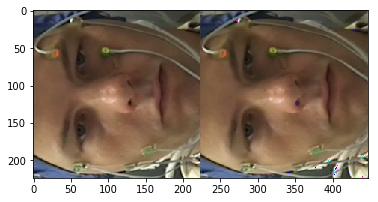

In [70]:
original = cv2.imread(image_path)[..., ::-1]
image_tensor = transform(image=original)['image']
out, r1, r2, z = model(image_tensor.unsqueeze(0).cuda())
original = np.swapaxes(image_tensor.cpu().detach().numpy(), 0, 2)
reconstruct = np.swapaxes(out.squeeze(0).cpu().detach().numpy(), 0, 2)
vis = np.concatenate((original, reconstruct), axis=1)
imshow((vis * 255).astype('uint8'))

In [84]:
model = VAE_CNN()
#model.apply(train_utils.weights_init)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = customLoss()
#optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
#criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()

In [85]:
with warnings.catch_warnings():
    model = model.cuda()
    warnings.filterwarnings('ignore')
    train_losses, test_losses, test_r2_losses, train_r2_losses, model = train(model, train_loader, valid_loader, optimizer, criterion, BATCH_SIZE, epochs=60)

Train Epoch: 1 [0/3825 (0%)]	Loss: 900.104797, MSE: 55613.289062, KLD: 343.971924
Train Epoch: 1 [2000/3825 (13%)]	Loss: 0.073266, MSE: 3820.146973, KLD: 18.360987
Train Epoch: 1 [4000/3825 (26%)]	Loss: 0.053363, MSE: 3333.854980, KLD: 13.396445
Train Epoch: 1 [6000/3825 (39%)]	Loss: 0.017928, MSE: 3109.273926, KLD: 9.997615
Train Epoch: 1 [8000/3825 (52%)]	Loss: 0.009957, MSE: 2981.942383, KLD: 8.003053
Train Epoch: 1 [10000/3825 (65%)]	Loss: 0.009294, MSE: 2908.013916, KLD: 6.766737
Train Epoch: 1 [12000/3825 (78%)]	Loss: 0.010495, MSE: 2856.951660, KLD: 5.937788
Train Epoch: 1 [14000/3825 (92%)]	Loss: 0.008026, MSE: 2817.003906, KLD: 5.296810

====> Epoch: 1 Average loss: 32.8920



====> Test set loss: 26.3671


Train Epoch: 2 [0/3825 (0%)]	Loss: 26.680355, MSE: 2450.895508, KLD: 2.171399
Train Epoch: 2 [2000/3825 (13%)]	Loss: 0.055351, MSE: 2569.909668, KLD: 1.622479
Train Epoch: 2 [4000/3825 (26%)]	Loss: 0.034592, MSE: 2576.429199, KLD: 1.605431
Train Epoch: 2 [6000/3825 (39%)]	Loss: 0.012608, MSE: 2555.833008, KLD: 1.599840
Train Epoch: 2 [8000/3825 (52%)]	Loss: 0.013406, MSE: 2537.204346, KLD: 1.625037
Train Epoch: 2 [10000/3825 (65%)]	Loss: 0.008731, MSE: 2542.782227, KLD: 1.649722
Train Epoch: 2 [12000/3825 (78%)]	Loss: 0.010909, MSE: 2540.975830, KLD: 1.669635
Train Epoch: 2 [14000/3825 (92%)]	Loss: 0.006642, MSE: 2537.835449, KLD: 1.650696

====> Epoch: 2 Average loss: 26.9528



====> Test set loss: 26.6895


Train Epoch: 3 [0/3825 (0%)]	Loss: 24.599651, MSE: 2228.123047, KLD: 2.318423
Train Epoch: 3 [2000/3825 (13%)]	Loss: 0.062734, MSE: 2538.329590, KLD: 1.572037
Train Epoch: 3 [4000/3825 (26%)]	Loss: 0.035619, MSE: 2549.715576, KLD: 1.609574
Train Epoch: 3 [6000/3825 (39%)]	Loss: 0.011859, MSE: 2524.052734, KLD: 1.628535
Train Epoch: 3 [8000/3825 (52%)]	Loss: 0.010838, MSE: 2513.901611, KLD: 1.623235
Train Epoch: 3 [10000/3825 (65%)]	Loss: 0.009783, MSE: 2517.842041, KLD: 1.645417
Train Epoch: 3 [12000/3825 (78%)]	Loss: 0.009298, MSE: 2513.450928, KLD: 1.666625
Train Epoch: 3 [14000/3825 (92%)]	Loss: 0.006696, MSE: 2511.569092, KLD: 1.641590

====> Epoch: 3 Average loss: 26.6717



====> Test set loss: 25.1783


Train Epoch: 4 [0/3825 (0%)]	Loss: 24.952461, MSE: 2322.409424, KLD: 1.728366
Train Epoch: 4 [2000/3825 (13%)]	Loss: 0.066855, MSE: 2523.309082, KLD: 1.769430
Train Epoch: 4 [4000/3825 (26%)]	Loss: 0.033876, MSE: 2530.938965, KLD: 1.693499


RuntimeError: CUDA out of memory. Tried to allocate 78.12 MiB (GPU 0; 15.75 GiB total capacity; 13.38 GiB already allocated; 80.94 MiB free; 329.81 MiB cached)

In [21]:
torch.save(model, './models/baseline_vae_full_isic_3_epochs.pth.tar')

/home/alisa/anaconda3/envs/myenv/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type VAE_CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [86]:
with torch.no_grad():
        orig = torch.randn(64, 2048).cuda()
        sample = model.decode(orig).cpu()
        #vis = np.concatenate((orig.cpu().detach().numpy(), sample.view(64, 3, 100, 100).cpu().detach().numpy()), axis=1)
        imshow((vis * 255).astype('uint8'))
        show()
        time.sleep(0.01)
        #save_image(sample.view(64, 3, 100, 100),
        #           '../results/sample_' + str(epoch) + '.png')

RuntimeError: CUDA out of memory. Tried to allocate 39.12 MiB (GPU 0; 15.75 GiB total capacity; 13.43 GiB already allocated; 40.94 MiB free; 328.06 MiB cached)

In [68]:
image_path = '../EmotionDetection/DEAP/aligned_faces/s01/s01_trial01/thumbs21.png'
image_path2 = '../EmotionDetection/DEAP/aligned_faces/s01/s01_trial01/thumbs21.png'
transform = Compose([Resize(100, 100),
                                ToTensor(normalize={'mean': MEAN, 'std': VAR})])

In [76]:
imgs = []
original = cv2.imread(image_path)[..., ::-1]
image_tensor = transform(image=original)['image']
imgs.append(image_tensor)

original = cv2.imread(image_path2)[..., ::-1]
image_tensor = transform(image=original)['image']
imgs.append(image_tensor)

original = cv2.imread(join(IMAGES_DIR, X_test[0]))[..., ::-1]
image_tensor = transform(image=original)['image']
imgs.append(image_tensor)
imgs = torch.stack(imgs)

In [77]:
print(imgs.shape)

torch.Size([3, 3, 100, 100])


In [80]:
sample = torch.randn(64, 2048).cuda()

In [81]:
sample

tensor([[ 1.5543,  1.1140, -0.1804,  ...,  0.5509,  0.2900, -0.6081],
        [ 1.3778, -0.4791,  0.1410,  ..., -2.1567,  1.2564, -1.9599],
        [ 0.1704, -1.4175,  0.8923,  ..., -0.6681, -1.3015, -1.8868],
        ...,
        [ 0.7172,  1.2614,  0.7653,  ...,  0.1361,  0.5402,  0.0667],
        [-0.7420,  0.9209, -1.0169,  ..., -2.1689,  0.0419,  0.5510],
        [-1.2610,  0.2991,  0.5455,  ...,  0.2612,  0.6245, -0.8193]],
       device='cuda:0')

torch.Size([3, 3, 100, 100])


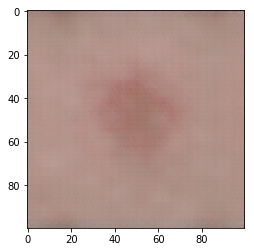

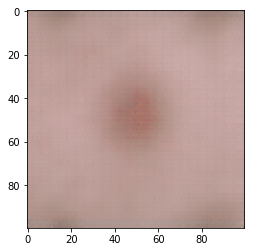

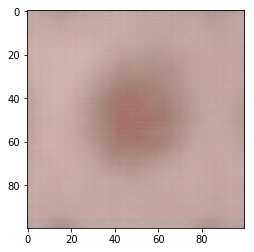

In [82]:
with torch.no_grad():
        #sample = torch.randn(64, 2048).cuda()
        sample, _, _ = model(imgs.cuda())
        #images = sample.view(3, 3, 100, 100)
        print(sample.shape)
        for im in sample:
            im = np.swapaxes(im.cpu(), 0, 2)
            imshow(im)
            show()
            time.sleep(0.01)

In [15]:
for batch_idx, data in tqdm_notebook(enumerate(valid_loader), desc='train', total=len(valid_loader)):
    data = data.cuda()
    out, r1, r2, z = model(data)
    for i, (original, reconstruct, z_i) in enumerate(zip(data.cpu().detach().numpy(), out.cpu().detach().numpy(), z.cpu().detach().numpy())): 
        print("Probability: "+ str(np.prod(z_i)))
        original = np.swapaxes(original, 0, 2)
        reconstruct = np.swapaxes(reconstruct, 0, 2)
        vis = np.concatenate((original, reconstruct), axis=1)
        imshow((vis * 255).astype('uint8'))
        show()
        time.sleep(0.01)
        #axarr[i,0].imshow((original * 255).astype('uint8'))
        #axarr[i,1].imshow((reconstruct * 255).astype('uint8'))
    break

NameError: name 'valid_loader' is not defined